In [2]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import LocalOutlierFactor # not used
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [16]:
def k_mean(K, X):
    k_model = KMeans(n_clusters=K)
    k_model.fit(X)
    y_pred = k_model.predict(X)
    centroids = k_model.cluster_centers_
    
    %matplotlib inline
    plt.scatter(X.iloc[:,0],X.iloc[:,1], c=y_pred)
    plt.scatter(centroids[:,0],centroids[:,1], marker='x', s = 200, linewidths=2)
    plt.xlabel('Canonical variable 1')
    plt.ylabel('Canonical variable 2')
    plt.title('ScatterplotCanonical Variables for 4 Clusters')
    plt.show()

In [4]:
def find_k_graph(kTests, data):
    # k-means cluster analysis
    clusters=range(1,kTests+1)
    meandist=[]
    
    for k in clusters:
        model=KMeans(n_clusters=k)
        model.fit(data)
        clusassign=model.predict(data)
        meandist.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
    # Identify number of clusters
    %matplotlib inline
    plt.plot(clusters, meandist)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average distance')
    plt.title('Selecting K with the Elbow Method')

# NSL-KDD Dataset

In [5]:
testFile = arff.loadarff('KDDTest+.arff')
trainFile = arff.loadarff('KDDTrain+.arff')
testDF = pd.DataFrame(testFile[0])
trainDF = pd.DataFrame(trainFile[0])
testDF

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,b'tcp',b'private',b'REJ',0.0,0.0,b'0',0.0,0.0,0.0,...,10.0,0.04,0.06,0.00,0.00,0.00,0.00,1.00,1.00,b'anomaly'
1,0.0,b'tcp',b'private',b'REJ',0.0,0.0,b'0',0.0,0.0,0.0,...,1.0,0.00,0.06,0.00,0.00,0.00,0.00,1.00,1.00,b'anomaly'
2,2.0,b'tcp',b'ftp_data',b'SF',12983.0,0.0,b'0',0.0,0.0,0.0,...,86.0,0.61,0.04,0.61,0.02,0.00,0.00,0.00,0.00,b'normal'
3,0.0,b'icmp',b'eco_i',b'SF',20.0,0.0,b'0',0.0,0.0,0.0,...,57.0,1.00,0.00,1.00,0.28,0.00,0.00,0.00,0.00,b'anomaly'
4,1.0,b'tcp',b'telnet',b'RSTO',0.0,15.0,b'0',0.0,0.0,0.0,...,86.0,0.31,0.17,0.03,0.02,0.00,0.00,0.83,0.71,b'anomaly'
5,0.0,b'tcp',b'http',b'SF',267.0,14515.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.01,0.03,0.01,0.00,0.00,0.00,b'normal'
6,0.0,b'tcp',b'smtp',b'SF',1022.0,387.0,b'0',0.0,0.0,0.0,...,28.0,0.11,0.72,0.00,0.00,0.00,0.00,0.72,0.04,b'normal'
7,0.0,b'tcp',b'telnet',b'SF',129.0,174.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.01,0.01,0.02,0.02,b'anomaly'
8,0.0,b'tcp',b'http',b'SF',327.0,467.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.01,0.03,0.00,0.00,0.00,0.00,b'normal'
9,0.0,b'tcp',b'ftp',b'SF',26.0,157.0,b'0',0.0,0.0,0.0,...,26.0,0.50,0.08,0.02,0.00,0.00,0.00,0.00,0.00,b'anomaly'


In [6]:
train_data = trainDF[['src_bytes', 'dst_bytes', 'num_failed_logins', 'logged_in', 'num_compromised', 
            'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
            'num_access_files', 'num_outbound_cmds']]
# test_data = testDF[['src_bytes', 'dst_bytes', 'num_failed_logins', 'logged_in', 'num_compromised', 
#             'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
#             'num_access_files', 'num_outbound_cmds']]
train_data

,src_bytes,dst_bytes,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds
0,491.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,146.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,232.0,8153.0,0.0,b'1',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,199.0,420.0,0.0,b'1',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train_x, test_x, train_y, test_y = train_test_split(trainDF[['src_bytes']], trainDF[['dst_bytes']],random_state=42)

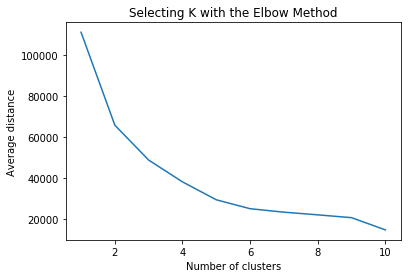

In [7]:
find_k_graph(10, train_data)

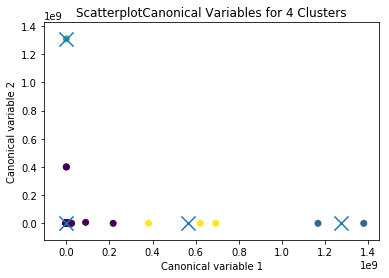

In [17]:
k_mean(4, train_data)

# Kaggle Dataset

In [10]:
kaggleDF = pd.read_csv("cs448b_ipasn.csv")
kaggleDF

,date,l_ipn,r_asn,f
0,2006-07-01,0,701,1
1,2006-07-01,0,714,1
2,2006-07-01,0,1239,1
3,2006-07-01,0,1680,1
4,2006-07-01,0,2514,1
5,2006-07-01,0,3320,1
6,2006-07-01,0,3561,13
7,2006-07-01,0,4134,3
8,2006-07-01,0,5617,2
9,2006-07-01,0,6478,1


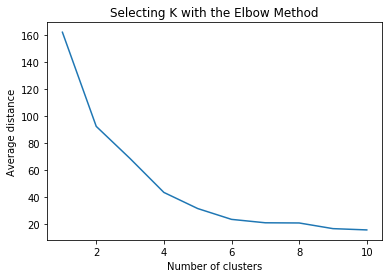

In [11]:
find_k_graph(10, kaggleDF[["l_ipn","f"]])

<IPython.core.display.Javascript object>


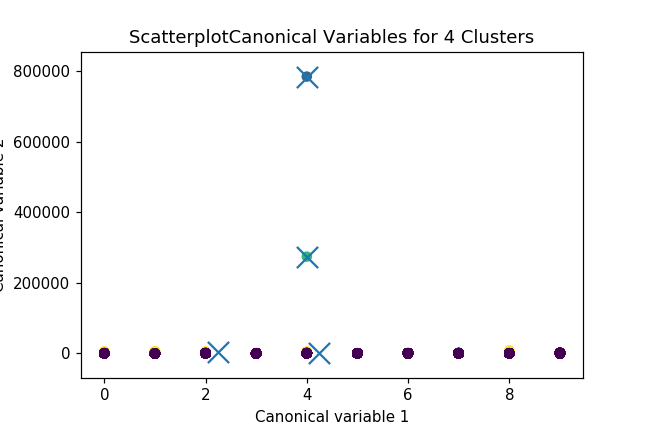

In [12]:
k_mean(4, kaggleDF[["l_ipn","f"]])

# CIDDS Dataset

In [10]:
print("hello world")

hello world
